In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.api import OLS, add_constant

from statsmodels.tsa.statespace.sarimax import SARIMAX

plt.rcParams["figure.figsize"] = (16, 9)  # Figure size and width

In [2]:
#Omitted Variable Bias Simulation
#Data-generating process

alpha = 0.0          # intercept
beta  = 0.8          # true coefficient on X
delta = 1.2          # effect of omitted Z
rho   = 0.7          # corr(X,Z)
sigma_eps = 0.8      # SD of epsilon

In [3]:
# Monte-Carlo settings

sample_sizes = [50, 300, 2000]   # small, medium, large n
reps = 800                       # repetitions
selected_n = 300                 # size for histogram plot
np.random.seed(4242)             # reproducibility

In [4]:
#Simulation loop

summary_rows = []
beta_full_sel = None
beta_omit_sel = None

for n in sample_sizes:
    beta_full = np.empty(reps)
    beta_omit = np.empty(reps)
    for r in range(reps):
        # Generate correlated X and Z
        X = np.random.normal(0, 1, n)
        u = np.random.normal(0, 1, n)
        Z = rho * X + np.sqrt(1 - rho**2) * u

        # Outcome
        eps = np.random.normal(0, sigma_eps, n)
        Y = alpha + beta * X + delta * Z + eps

        # Full model: Y ~ X + Z
        X_full = add_constant(np.column_stack((X, Z)))
        beta_full[r] = OLS(Y, X_full).fit().params[1]

        # Reduced model: Y ~ X  (omit Z)
        X_red = add_constant(X)
        beta_omit[r] = OLS(Y, X_red).fit().params[1]

    if n == selected_n:
        beta_full_sel = beta_full
        beta_omit_sel = beta_omit

    summary_rows.append({
        "n": n,
        "mean_beta_full": beta_full.mean(),
        "sd_beta_full": beta_full.std(ddof=1),
        "bias_beta_full": beta_full.mean() - beta,
        "mean_beta_omit": beta_omit.mean(),
        "sd_beta_omit": beta_omit.std(ddof=1),
        "bias_beta_omit": beta_omit.mean() - beta
    })

summary = pd.DataFrame(summary_rows)
print("\nMonte Carlo Summary\n", summary)



Monte Carlo Summary
       n  mean_beta_full  sd_beta_full  bias_beta_full  mean_beta_omit  \
0    50        0.798122      0.166567       -0.001878        1.637012   
1   300        0.801978      0.063730        0.001978        1.642243   
2  2000        0.800746      0.024714        0.000746        1.641987   

   sd_beta_omit  bias_beta_omit  
0      0.172766        0.837012  
1      0.065205        0.842243  
2      0.025419        0.841987  


In [5]:
#Theoretical probability limit

plim_omit = beta + delta * rho
print(f"\nTheoretical plim of β_hat (omit Z) = {plim_omit:.3f}")



Theoretical plim of β_hat (omit Z) = 1.640


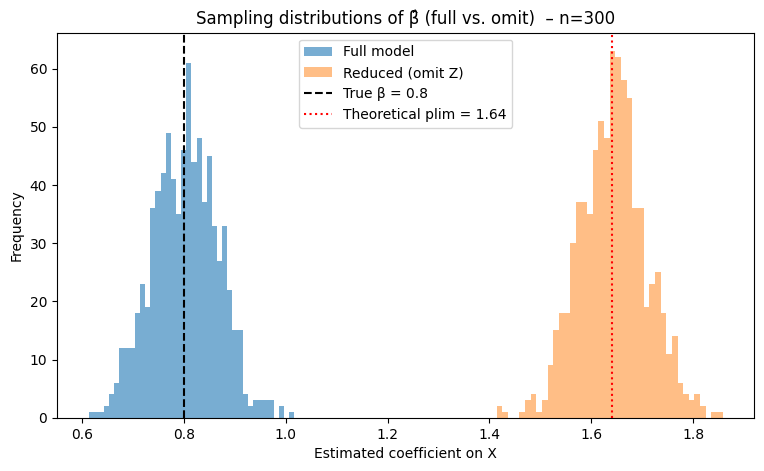

In [6]:
#Plots
# Histogram of sampling distributions at n=300

plt.figure(figsize=(9,5))
plt.hist(beta_full_sel, bins=40, alpha=0.6, label="Full model")
plt.hist(beta_omit_sel, bins=40, alpha=0.5, label="Reduced (omit Z)")
plt.axvline(beta, color="black", ls="--", label=f"True β = {beta}")
plt.axvline(plim_omit, color="red", ls=":", label=f"Theoretical plim = {plim_omit:.2f}")
plt.title("Sampling distributions of β̂ (full vs. omit)  – n=300")
plt.xlabel("Estimated coefficient on X")
plt.ylabel("Frequency")
plt.legend()
plt.show()


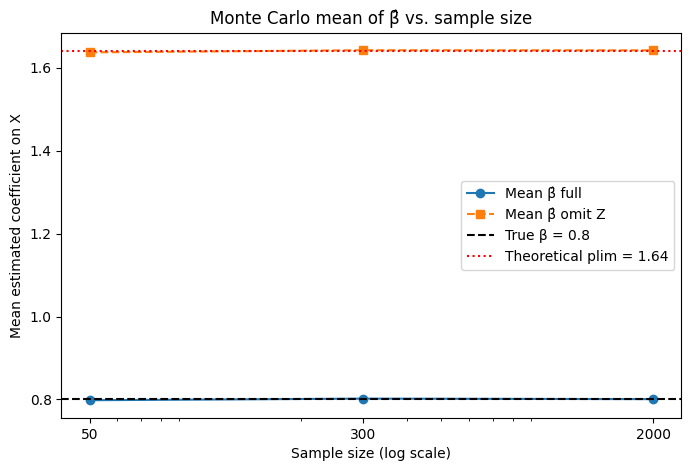

In [7]:
# Mean estimate vs. sample size

plt.figure(figsize=(8,5))
plt.plot(summary["n"], summary["mean_beta_full"], "o-", label="Mean β̂ full")
plt.plot(summary["n"], summary["mean_beta_omit"], "s--", label="Mean β̂ omit Z")
plt.axhline(beta, color="black", ls="--", label=f"True β = {beta}")
plt.axhline(plim_omit, color="red", ls=":", label=f"Theoretical plim = {plim_omit:.2f}")
plt.xscale("log")
plt.xticks(summary["n"], summary["n"])
plt.title("Monte Carlo mean of β̂ vs. sample size")
plt.xlabel("Sample size (log scale)")
plt.ylabel("Mean estimated coefficient on X")
plt.legend()
plt.show()